In [1]:
# import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
# import math
# from networkx import minimum_cut, DiGraph
from mip import *
# from itertools import product

from src.read_instance import MDOVRP
# rnd = np.random
# rnd.seed(454)

In [2]:
# filepath = "Instancias/ES-n78-m2-Q10138.txt"
filepath = "Instancias/Vrp-Set-A/A-n80-m2-Q60.vrp"

In [3]:
N, D, V, Q, q, c, coord_x, coord_y = MDOVRP(filepath)

In [4]:
# fazendo c ser simétrica
# c = {(i,j) : (c[i,j] + c[j, i])/2  for (i,j) in c}

Usando a formulação $MDOVRP_{2i− flv}$ de Lalla-Ruiz e Mes (2019)


    Lalla-Ruiz, Eduardo, and Martijn Mes. "Mathematical formulations and improvements for the multi-depot open vehicle routing problem." Optimization Letters 15 (2021): 271-286.

In [5]:
#cria o modelo
model = Model('PRVMD', solver_name = GUROBI)

# Variaveis de decisao
x = [[model.add_var(var_type=BINARY) if i!=j else model.add_var(lb=0, ub=0) for i in V] for j in V]
u = [[model.add_var(var_type=CONTINUOUS) if i!=j else model.add_var(lb=0, ub=0) for i in V] for j in V]
y = [model.add_var(var_type=BINARY) for i in N]

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID
Academic license - for non-commercial use only - registered to thiago.giachetto@aluno.ufop.edu.br


\begin{equation}
\label{eq:9}
    x_{ij} \in \{0, 1\}, \quad \forall i, j \in V
\end{equation}

\begin{equation}
\label{eq:10}
    u_{ij} \geq 0, \quad \forall i, j \in V
\end{equation}

In [6]:
# Funcao objetivo
M = 10

# model.objective = minimize(xsum(x[i][j] * c[i,j] for i in V for j in V if i != j))
model.objective = minimize(xsum(x[i][j] * c[i,j] for i in V for j in V if i != j) - 
                           M*xsum(x[i][j] * q[j] for i in V for j in N if i != j))

\begin{equation}
\label{eq:1}
 Minimizar \quad \sum_{i \in V }\sum_{j \in V} c_{ij}x_{ij}
\end{equation}

In [7]:
# Restricao 2
for j in N:
#     model += xsum(x[i][j] for i in V if i != j and c[i][j] <= 180) == 1
#     model += xsum(x[i][j] for i in V if i != j) == 1
    model += xsum(x[i][j] for i in V if i != j) <= 1

\begin{equation}
    \sum_{i \in V, i \neq j}x_{ij} = 1, \quad \forall j \in N
    \tag{2}
\end{equation}

In [8]:
# Restricao 18

for j in N:
    model += (xsum(x[i][j] for i in V if i != j) - xsum(x[j][i] for i in N if i != j)) >= 0

\begin{equation}
    \sum_{i \in V, i \neq j}x_{ij} - \sum_{i \in N, i \neq j}x_{ji} \geq 0, \quad \forall j \in N
    \tag {18}
\end{equation}

In [9]:
# Restricao 19
for i in V:
    for j in V:
        if i != j:
            model += x[i][j] + x[j][i] <= 1

\begin{equation}
    x_{ij} + x_{ji} \leq 1, \quad \forall i, j \in V, i \neq j
    \tag {19}
\end{equation}

In [10]:
# Restricao 20
# Ninguem volta para o depósito
model += xsum(x[j][k] for k in D for j in V) == 0

\begin{equation}
    \sum_{k \in D}\sum_{j \in V}x_{jk} = 0
    \tag {20}
\end{equation}

In [11]:
# Restricao 21
for j in N:
#     model += xsum(u[i][j] for i in V if i != j) - xsum(u[j][i] for i in V if i != j) >= q[j]
    model += xsum(u[i][j] for i in V if i != j) - xsum(u[j][i] for i in V if i != j) >= xsum(x[i][j]*q[j] for i in V if i != j)

\begin{equation}
    \sum_{i \in V, i \neq j}u_{ij} - \sum_{i \in V, i \neq j}u_{ji} \geq q_j, \quad \forall j \in N
    \tag {21}
\end{equation}

In [12]:
#Restricao 22
for i in N:
    for j in N:
        model += (Q - q[i])*x[i][j] >= u[i][j]

\begin{equation}
    (Q - q_i) \cdot x_{ij} \geq u_{ij}, \quad \forall i, j \in N
    \tag {22}
\end{equation}

In [13]:
# Restricao 23
for k in D:
    for j in N:
        model += Q * x[k][j] >= u[k][j]

\begin{equation}
    Q \cdot x_{kj} \geq u_{kj}, \quad \forall k \in D, j \in N
    \tag {23}
\end{equation}

In [14]:
# # Restricao 8
# d = [min([c[j, i] for j in D]) for i in N]
# r = [min([c[j, i] for j in N if i != j]) for i in N]
# M = max(r)

# for i in N:
#     model += d[i] + M * y[i] >= r[i]

\begin{equation}
    d_{i} + M y_{i} \geq r_{i}, \quad \forall k \in N
    \tag {8}
\end{equation}

In [15]:
# # Restricao 9

# for i in N:
#     k_l = D[np.argmin([c[j, i] for j in D], axis=0)]
#     model += x[k_l][i] >= y[i]

\begin{equation}
    x_{k'i} \geq y_{i}, \quad \forall i \in N, k' = argmin(c_{ki})_{k \in D}
    \tag {9}
\end{equation}

In [16]:
# # Restricao 10

# model += xsum(x[k][i] for i in N for k in D) >= np.ceil(sum(q)/Q)

\begin{equation}
    \sum_{i \in N}\sum_{k \in D}x_{ki} \geq \lceil \frac{\sum_{i \in N} q_{i}}{Q} \rceil
    \tag {10}
\end{equation}

In [17]:
# # Restricao de distancia maxima entre duas cidades

# for i in V:
#     for j in V:
#         if i != j:
#             model += c[i,j]*x[i][j] <= 180

In [18]:
# limite de carros total
NUM_VEICULOS = 8

model += xsum(x[k][i] for k in D for i in V) <= NUM_VEICULOS

In [19]:
# Resolve o modelo        
# model.optimize(max_seconds=7200)
model.optimize(max_seconds=30)
print("status: {} objective value : {} best possible: {}".format(model.status, model.objective_value, model.objective_bound))


#                   Objective                Residual
# Iter       Primal          Dual         Primal    Dual     Compl     Time
# usando c simétrica
# 421367 260494 2594.76360   95  102 2608.15000 2560.04596  1.84%   117 7200s
# usando c original
# 351473 211907 2581.12423   69  161 2608.75395 2552.97499  2.14%   138 7200s

Set parameter TimeLimit to value 30
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Academic license - for non-commercial use only - registered to thiago.giachetto@aluno.ufop.edu.br
Optimize a model with 13444 rows, 13528 columns and 65452 nonzeros
Model fingerprint: 0xa56a9c07
Variable types: 6806 continuous, 6722 integer (6722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [4e-01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Found heuristic solution: objective 0.0000000
Presolve removed 3723 rows and 728 columns
Presolve time: 0.34s
Presolved: 9721 rows, 12800 columns, 50960 nonzeros
Variable types: 6320 continuous, 6480 integer (6480 binary)
Found heuristic solution: obje

    29    32 -3355.0683   12  137 -3309.9710 -3356.8623  1.42%   289   30s

Cutting planes:
  Lift-and-project: 18
  Implied bound: 33
  MIR: 40
  Flow cover: 44
  GUB cover: 3
  Zero half: 3
  RLT: 6
  Relax-and-lift: 4

Explored 31 nodes (67215 simplex iterations) in 30.00 seconds (13.90 work units)
Thread count was 4 (of 4 available processors)

Solution count 9: -3309.97 -3291.75 -3288.41 ... 0

Time limit reached
Best objective -3.309971019063e+03, best bound -3.356862337182e+03, gap 1.4167%
status: OptimizationStatus.FEASIBLE objective value : -3309.9710190626565 best possible: -3356.862337181724


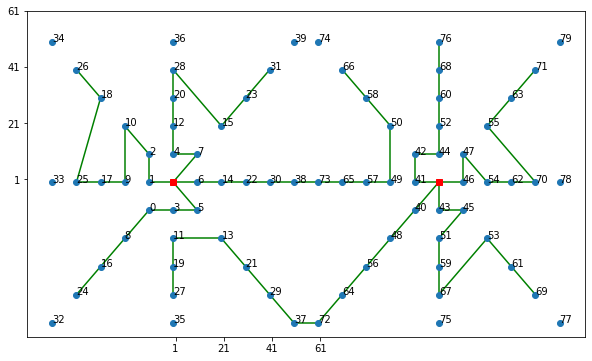

In [20]:
# --- PLOTA O GRAFICO ---
plt.figure(figsize=(10, 6))
plt.scatter(coord_x[0:], coord_y[0:])
for i in N:
    plt.annotate(f"{i}", (coord_x[i], coord_y[i]))
for i in D:
    plt.plot(coord_x[i], coord_y[i], c = 'r', marker = 's')

for i in V:
    for j in V:
        if x[i][j].x > 0:
            plt.plot([coord_x[i], coord_x[j]], [coord_y[i], coord_y[j]], c='g', zorder=0)
    
#escala dos eixos
plt.yticks([i for i in range(1,80,20)]); 
plt.xticks([i for i in range(1,80,20)]); 

In [21]:
# para onde cada veículo vai
for k in D:
    print(f"{k} - ", end='')
    print([i for i, el in enumerate(u[k]) if el.x > 0])

80 - [1, 5, 6, 7]
81 - [40, 41, 43, 46]


In [22]:
# # u matrix
# for i in N:
#     print(f"{i} - ", end='')
#     print([(j, int(el.x)) for j, el in enumerate(u[i]) if el.x > 0])

In [23]:
# caminho dos carros olhando arcos
for k in D:
    print(f"Depot: {k}")
    for i, el in enumerate(x[k]):
        if el.x > 0:
            visitados = [i]
            next_list = [j for j, el in enumerate(x[i]) if el.x > 0]
            while len(next_list) > 0:
                if len(next_list) > 1:
                    print(f"ERROR: {next_list}")
                next_el = next_list[0]
                visitados.append(next_el)
                next_list = [j for j, el in enumerate(x[next_el]) if el.x > 0]
            print(visitados)

Depot: 80
[1, 2, 10, 9, 17, 25, 18, 26]
[5, 3, 0, 8, 16, 24]
[6, 14, 22, 30, 38, 73, 65, 57, 49, 50, 58, 66]
[7, 4, 12, 20, 28, 15, 23, 31]
Depot: 81
[40, 48, 56, 64, 72, 37, 29, 21, 13, 11, 19, 27]
[41, 42, 44, 52, 60, 68, 76]
[43, 45, 51, 59, 67, 53, 61, 69]
[46, 47, 54, 62, 70, 55, 63, 71]


In [24]:
# caminho dos carros olhando demanda
for k in D:
    print(f"Depot: {k}")
    for i, el in enumerate(u[k]):
        if el.x > 0:
            visitados = [(i, int(el.x))]
            next_list = [(j, int(el.x)) for j, el in enumerate(u[i]) if el.x > 0]
            while len(next_list) > 0:
                if len(next_list) > 1:
                    print(f"ERROR: {next_list}")
                next_el, value = next_list[0]
                visitados.append((next_el, value))
                next_list = [(j, int(el.x)) for j, el in enumerate(u[next_el]) if el.x > 0]
            print([(*el, q[el[0]]) for el in visitados])

Depot: 80
[(1, 60, 12), (2, 48, 12), (10, 36, 8), (9, 28, 8), (17, 20, 4), (25, 7, 2), (18, 5, 4), (26, 1, 2)]
[(5, 60, 12), (3, 37, 12), (0, 25, 12), (8, 13, 8), (16, 5, 4), (24, 1, 2)]
[(6, 60, 12), (14, 48, 8), (22, 40, 4), (30, 36, 2), (38, 34, 1), (73, 33, 1), (65, 32, 2), (57, 30, 4), (49, 26, 8), (50, 18, 8), (58, 5, 4), (66, 1, 2)]
[(7, 60, 12), (4, 48, 12), (12, 36, 8), (20, 28, 4), (28, 24, 2), (15, 22, 8), (23, 5, 4), (31, 2, 2)]
Depot: 81
[(40, 60, 12), (48, 48, 8), (56, 40, 4), (64, 36, 2), (72, 34, 1), (37, 33, 1), (29, 32, 2), (21, 30, 4), (13, 26, 8), (11, 18, 8), (19, 5, 4), (27, 1, 2)]
[(41, 60, 12), (42, 48, 12), (44, 36, 12), (52, 24, 8), (60, 16, 4), (68, 12, 2), (76, 10, 1)]
[(43, 60, 12), (45, 48, 12), (51, 36, 8), (59, 19, 4), (67, 15, 2), (53, 13, 8), (61, 5, 4), (69, 1, 2)]
[(46, 60, 12), (47, 48, 12), (54, 36, 8), (62, 28, 4), (70, 24, 2), (55, 22, 8), (63, 5, 4), (71, 1, 2)]


In [25]:
# dist percorrida
sum([(1 if x[i][j].x>0.5 else 0) * c[i,j] for i in V for j in V if i != j])

900.0289809373432

In [26]:
for j in N:
    enter = int(sum([u[i][j].x for i in V if i != j]) - sum([u[j][i].x for i in N if i != j]))
    sum([x[i][j].x*q[j] for i in V if i != j])
    if enter < q[j]:
        print(f"{j}-> enter: {enter}  need: {q[j]}  const: {int(sum([x[i][j].x*q[j] for i in V if i != j]))}")

2-> enter: 11  need: 12  const: 12
3-> enter: 11  need: 12  const: 12
4-> enter: 11  need: 12  const: 12
8-> enter: 7  need: 8  const: 8
9-> enter: 7  need: 8  const: 8
10-> enter: 7  need: 8  const: 8
12-> enter: 7  need: 8  const: 8
13-> enter: 7  need: 8  const: 8
14-> enter: 7  need: 8  const: 8
18-> enter: 3  need: 4  const: 4
20-> enter: 3  need: 4  const: 4
21-> enter: 3  need: 4  const: 4
22-> enter: 3  need: 4  const: 4
23-> enter: 3  need: 4  const: 4
24-> enter: 1  need: 2  const: 2
26-> enter: 1  need: 2  const: 2
27-> enter: 1  need: 2  const: 2
28-> enter: 1  need: 2  const: 2
29-> enter: 1  need: 2  const: 2
30-> enter: 1  need: 2  const: 2
32-> enter: 0  need: 1  const: 0
33-> enter: 0  need: 1  const: 0
34-> enter: 0  need: 1  const: 0
35-> enter: 0  need: 1  const: 0
36-> enter: 0  need: 1  const: 0
37-> enter: 0  need: 1  const: 1
38-> enter: 0  need: 1  const: 1
39-> enter: 0  need: 1  const: 0
42-> enter: 11  need: 12  const: 12
44-> enter: 11  need: 12  const: 12


In [27]:
# nao atendidos
# [j for j in N if ((sum([u[i][j].x for i in V if i != j]) - sum([u[j][i].x for i in N if i != j])) < q[j])]
not_served = [j for j in N if (int(sum([u[i][j].x for i in V if i != j]) - sum([u[j][i].x for i in N if i != j])) < q[j])]
print(len(not_served))
not_served
# [q[j] for j in N]

56


[2,
 3,
 4,
 8,
 9,
 10,
 12,
 13,
 14,
 18,
 20,
 21,
 22,
 23,
 24,
 26,
 27,
 28,
 29,
 30,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 42,
 44,
 45,
 47,
 48,
 52,
 54,
 56,
 57,
 58,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 77,
 78,
 79]

In [28]:
# nro de veiculos
sum(x[k][i].x for k in D for i in N)

8.0

In [29]:
# cidades que tem mais de dois arcos ligadas a ela (depositos podem ter mais)
print([j for j in V if len([i for i in V if x[j][i].x > 0.5 or x[i][j].x > 0.5]) > 2])

[80, 81]


In [30]:
# [el.x for el in w]